# Prática 3

***Aprendizado Dinâmico***

por **Cibele Russo** (ICMC/USP - São Carlos SP)

**MBA em Ciências de Dados**

Considere as duas bases de dados a seguir

- Dados de fechamento do papel PETR4 de um período de março a julho de 2020 no arquivo PETR4.csv.

- Dados de casos confirmados para COVID-19 no estado de SP.


Nesta prática, aplicaremos os conhecimentos adquiridos na Aula 3 a esses dados, a saber:

- Função de autocorrelação

- Função de autocorrelação parcial

- Repetir a modelagem para os dados de PETR4 visto em aula.

- Para os dados de COVID-19: Um modelo ARIMA sazonal.

# A Bit of Theory

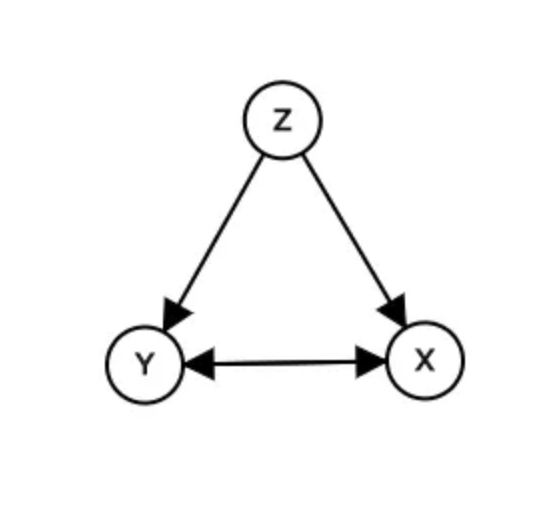

(-1.0, 50.0)

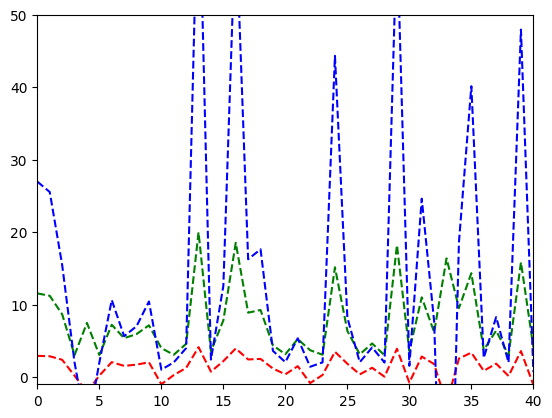

In [30]:
import numpy as np
from scipy import stats, linalg
import matplotlib.pyplot as plt
import random

random.seed(30)
mu1 = 2
sigma1 = 2
x = np.arange(100)
p1 =  np.random.normal(mu1,sigma1,100)
p2 = np.square(p1) + 3
p3 = np.power(p1,3) + 2
plt.figure
plt.plot(x, p1, 'r--',x, p2, 'g--',x, p3, 'b--')
plt.xlim(0, 40)
plt.ylim(-1, 50)

In [19]:
np.corrcoef(p2,p3)

array([[1.        , 0.97758294],
       [0.97758294, 1.        ]])

In [23]:
def partial_corr(p1,p2,p3):
    p1k = np.expand_dims(p1, axis=1)
    p2k = np.expand_dims(p2, axis=1)
    p3k = np.expand_dims(p3, axis=1)
    
    beta_p2k = linalg.lstsq(p1k, p2k)[0]  # Calculating Weights (W*)
    beta_p3k = linalg.lstsq(p1k, p3k)[0]  # Calculating Weights(W*)
    res_p2k = p2k - p1k.dot(beta_p2k) # Calculating Errors
    res_p3k = p3k - p1k.dot(beta_p3k) # Calculating Errors
    corr = stats.pearsonr(np.squeeze(res_p2k), np.squeeze(res_p3k))[0]
    return corr

partial_corr(p1,p2,p3)


0.85061794182079

## Interaction information

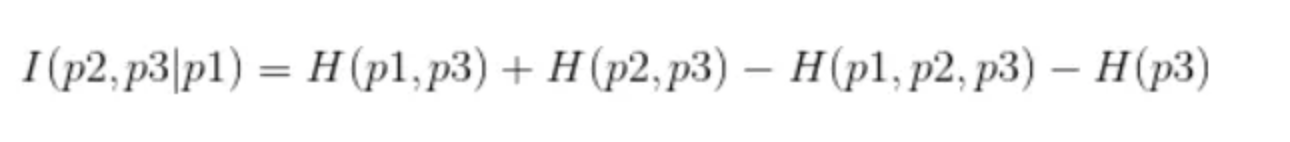

H(p2|p3):= H(p2,p3) - H(p3)

H(p2|p1,p3):= H(p3,p2,p1) - H(p3,p1)

$$I(p2,p3|p1) := H(p2|p3) - H(p2|p1,p3)

Say that P1 from our previous example was the number of clouds in the sky measured for 100 days. Let’s also assume that P2 is the level of darkness measured by a discrete lightmeter (amount of darkness is influenced by the amount of clouds) measured for 100 days and P3 is the amount of rain measured in milliliters for 100 days.

In [32]:
from pyitlib import discrete_random_variable as drv


p1 = np.round(p1) # to get integer values
p2 = np.round(p2) # to get integer values
p3 = np.round(p3) # to get integer values


MI = drv.information_mutual(p2,p3)

CMI = drv.information_mutual_conditional(p2,p3,p1)

InteractionInformation = MI - CMI

print(f'MI:{MI}, CMI:{CMI}, CoI:{InteractionInformation}')

MI:3.82093024410875, CMI:1.5023212434040705, CoI:2.3186090007046793


In [25]:
!pip install pyitlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 4.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 7.3 MB/s eta 0:00:0000:01
  Created wheel for pyitlib: filename=pyitlib-0.2.3-py3-none-any.whl size=29353 sha256=64112c6a9e9716a654384f07286ea3a5d2147a9389bd144dd2220abea9846a76
  Stored in directory: /Users/martinelligor/Library/Caches/pip/wheels/63/61/d0/1f7985cd4e0da752ef237db6efba814e4e8a229815369a7713
Successfully built pyitlib
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python3.7 -m pip install --upgrade pip


**1. Carregue as bibliotecas**

In [5]:
# Bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # para determinar (p,q)


# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

**2. Faça a leitura dos dados de PETR4 em df1 e de COVID-19 no estado de SP em df2. Para os dados PETR4 usaremos a variável Close e para os dados de COVID-19 usaremos a variável confirmed. Complete as bases de dados usando reindex e fillna.**

In [6]:
#pkgdir = '/hdd/MBA/AprendizadoDinamico/Data'

# PETR4 - Leitura dos dados
df1 = pd.read_csv('https://raw.githubusercontent.com/cibelerusso/Aprendizado-Dinamico/main/Data/PETR4.csv', index_col='Date', parse_dates=True)

idx1 = pd.date_range(start=df1.index.min(), end=df1.index.max(), freq='B')
df1 = df1.reindex(idx1)
df1.fillna(method='ffill', inplace=True)


# COVID-19 no estado de SP
df2 = pd.read_csv('https://raw.githubusercontent.com/cibelerusso/Aprendizado-Dinamico/main/Data/covidSP.csv', index_col='date', parse_dates=True)

idx2 = pd.date_range(start=df2.index.min(), end=df2.index.max(), freq='D')
df2 = df2.reindex(idx2)
df2.fillna(0,inplace=True)


**3. Verifique graficamente se os dados foram lidos de forma correta.**

<AxesSubplot:>

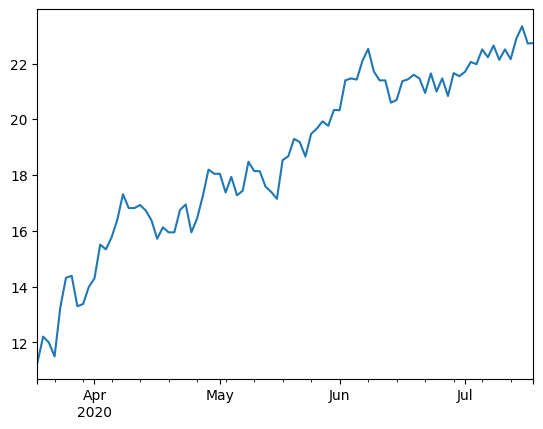

In [7]:
df1['Close'].plot()

<AxesSubplot:>

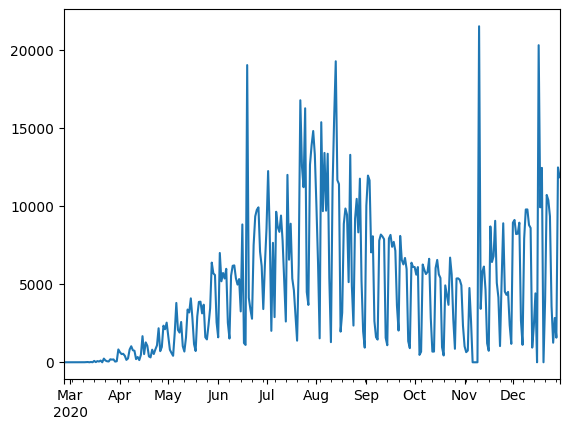

In [8]:
df2['confirmed'].plot()

**4. Obtenha os gráficos de autocorrelação e autocorrelação parcial para ambas as aplicações. Que características você observa nesses gráficos? Que modelo sugeriria com base nos correlogramas?**

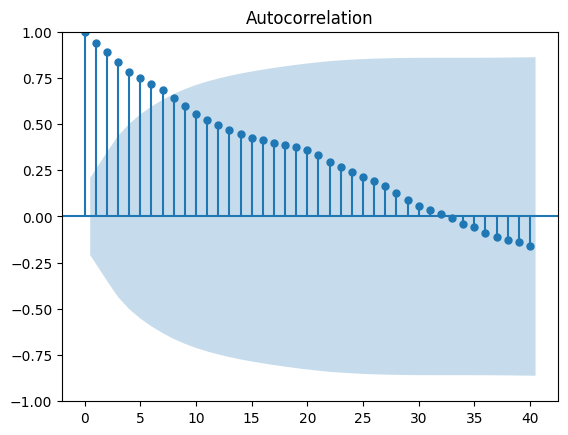

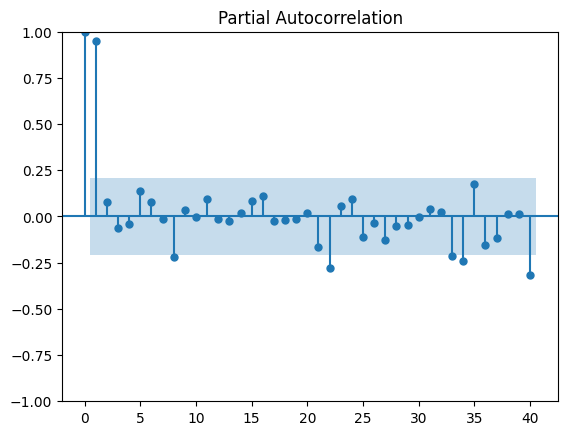

In [35]:
# Correlograma

plot_acf(df1['Close'], lags=40)
plot_pacf(df1['Close'], lags=40)
plt.show()

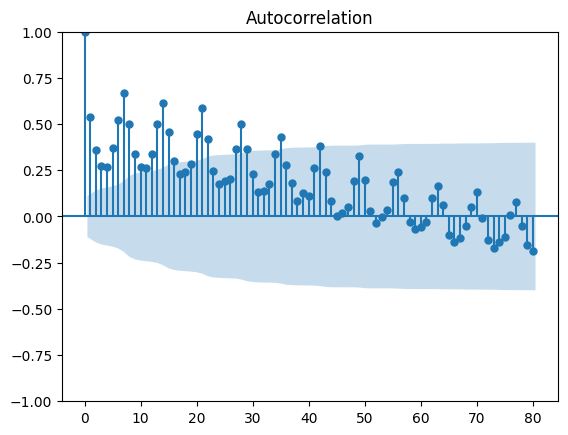

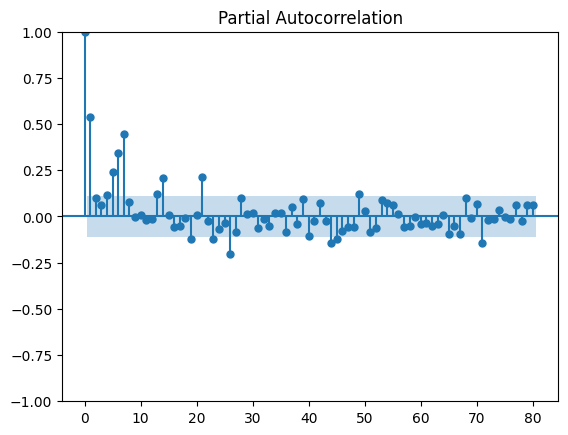

In [33]:

# Correlograma

plot_acf(df2['confirmed'], lags=80)
plot_pacf(df2['confirmed'], lags=80)
plt.show()

**5. Repita os gráficos de autocorrelação e autocorrelação parcial para a primeira diferença de cada aplicação. O que você pode concluir?**

In [11]:
df1.head(10)

,Open,High,Low,Close,Adj Close,Volume
2020-03-18,11.79,12.27,10.87,11.29,11.289389,162515200.0
2020-03-19,11.07,13.07,10.85,12.21,12.209339,157065200.0
2020-03-20,13.11,13.50,11.83,12.00,11.999351,149029900.0
2020-03-23,12.11,12.18,11.28,11.50,11.499378,107092400.0
2020-03-24,12.57,13.54,12.28,13.25,13.249283,114259200.0
2020-03-25,13.24,14.79,12.83,14.32,14.319224,158286200.0
2020-03-26,14.40,15.19,13.81,14.39,14.389221,130618400.0
2020-03-27,13.30,13.69,13.25,13.30,13.299280,101405900.0
2020-03-30,13.15,13.74,12.83,13.38,13.379276,110947200.0
2020-03-31,13.60,14.54,13.60,13.99,13.989244,156116500.0


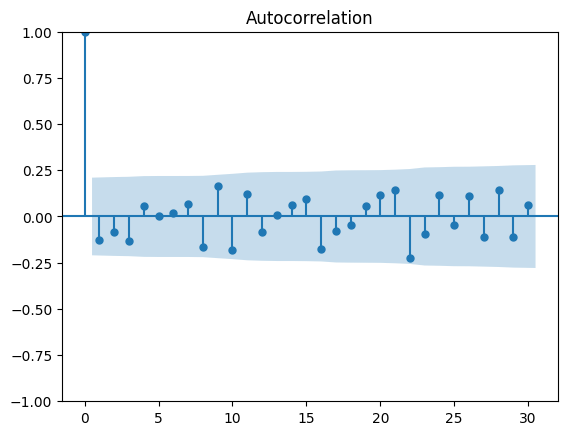

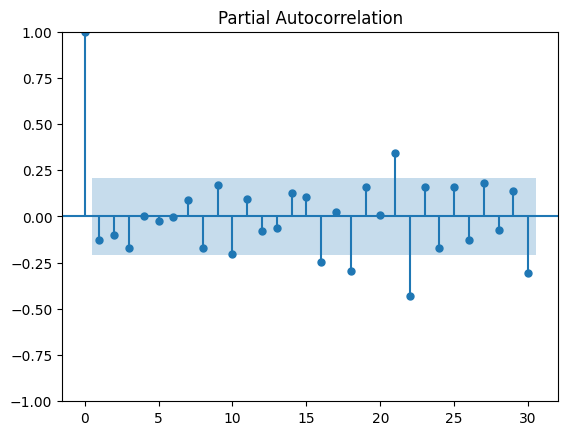

In [12]:
# Correlograma

plot_acf(np.diff(df1['Close']), lags=30)
plot_pacf(np.diff(df1['Close']), lags=30)
plt.show()

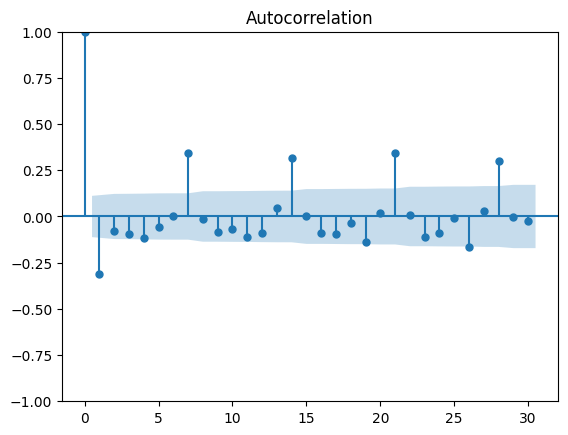

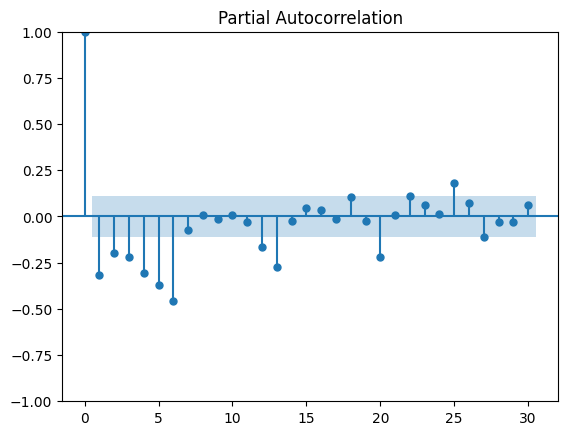

In [13]:
# Correlograma

plot_acf(np.diff(df2['confirmed']), lags=30)
plot_pacf(np.diff(df2['confirmed']), lags=30)
plt.show()

**6. Para os dados de PETR4, refaça a modelagem vista em aula.**

In [15]:
from pmdarima import auto_arima # Para determinar a ordem do ARIMA


In [36]:
stepwise_fit = auto_arima(df1['Close'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=0,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # se uma ordem não convergir, ignorar
                          suppress_warnings=True,  # ignorar avisos
                          stepwise=True)           # executar stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=152.390, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=153.013, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=152.598, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=154.944, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=152.746, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.709 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   88
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -74.195
Date:                Thu, 01 Aug 2024   AIC                            152.390
Time:                        21:28:49   BIC                            157.322
Sample:                    03-18-2020   HQIC                           154.376
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1316      0.062      2.124      0.034       0.010       0.253
sigma2         0.3223      0.053      6.046      0.000       0.218       0.427
===================================================================================
Ljung-Box (L1) (Q):                   1.40   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.24   Prob(JB):                         0.57
Heteroskedasticity (H):               0.57   Skew:                             0.25
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**7. Desafio: Ainda não vimos o modelo SARIMA, mas já sabemos que a série de COVID-19 tem sazonalidade. Como os dados de COVID-19 apresentam sazonalidade, vamos arriscar no tema da próxima aula? Altere seasonal para True e escolha o melhor modelo entre os SARIMA propostos. Discutiremos com detalhes este modelo na Aula 4.**

In [17]:
stepwise_fit = auto_arima(df2['confirmed'], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=7,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # se uma determinada ordem não convergir, ignorar
                          suppress_warnings=True,  # ignorar avisos
                          stepwise=True)           # executar stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5922.655, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=6007.140, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5916.437, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5845.769, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=6005.169, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=5891.230, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=5779.280, Time=0.46 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=5816.796, Time=0.25 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=5760.099, Time=0.70 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=5787.499, Time=0.69 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=5813.834, Time=0.67 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=5924.645, Time=0.56 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=5771.750, Time=0.72 sec
 ARIMA(0,1,2)(2,0,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  309
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -2874.364
Date:                           Thu, 01 Aug 2024   AIC                           5756.727
Time:                                   19:11:33   BIC                           5771.648
Sample:                               02-26-2020   HQIC                          5762.693
                                    - 12-30-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9021      0.027    -33.593      0.000      -0.955      -0.849
ar.S.L7        0.9673      0.034     28.507      0.000       0.901       1.034
ma.S.L7       -0.7733      0.067    -11.460      0.000      -0.906      -0.641
sigma2      7.315e+06   2.74e+05     26.680      0.000    6.78e+06    7.85e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):              2203.69
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):              16.15   Skew:                             1.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""